In [2]:
# import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC

import warnings 
warnings.filterwarnings("ignore")

In [3]:
# read in csv

df = pd.read_csv('../data/final_hurricane_labeled.csv')

print(df.shape)
df.head()

(41076, 7)


,Date,text_clean,label,n_sentence,n_words,lat,long
0,2020-08-31 23:15:25+00:00,a customer service rep told me friday there is...,0,2,11,25.525284,-80.606920
1,2020-08-31 22:39:25+00:00,tomorrow at pm after hour with sabor havana ci...,0,2,19,27.686273,-80.934588
2,2020-08-31 22:31:09+00:00,hurricane laura wallop area with high mortgage...,0,2,13,27.701712,-75.255859
3,2020-08-31 20:25:29+00:00,i never wish bad on anyone but think we need a...,0,1,9,29.114762,-84.339632
4,2020-08-31 19:51:39+00:00,wth is pricemart so full their a hurricane idk...,0,2,5,28.506867,-89.678090


In [4]:
# check null values

df.isnull().sum()

Date          0
text_clean    0
label         0
n_sentence    0
n_words       0
lat           0
long          0
dtype: int64

In [7]:
# define baseline accuracy

df['label'].value_counts(normalize = True)

0    0.526658
1    0.473342
Name: label, dtype: float64

In [8]:
# Modeling

In [9]:
# set up X and y and train test split

X = df['text_clean']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 42, stratify = y)

In [10]:
# create custom stop words

irrelevant_words = ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 
                  'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn', 'co', 'pm', 'wa', 'edt', 'amp', 'ha', 'cdt', 'one', 'state', 'hurricane', 'laura','hurricanelaura',
                   'trump', 'texas', 'louisiana', 'tx', 'houston']



In [11]:
# create a custom stop words list

print(len(stopwords.words('english')))

stop_words = stopwords.words('english') + irrelevant_words

print(len(stop_words))

179
216


In [12]:
### CountVectorizer()
#### Multinomial Naive Bayes and Support Vector Machine

In [13]:
# set 2 pipelines with: 1. Multinomial Bayes 2. Support Vector Machine

pipeline_mb = Pipeline([
                       ('cvec', CountVectorizer()),
                       ('mb', MultinomialNB())
                       ])

pipeline_svc = Pipeline([
                        ('cvec', CountVectorizer()),
                        ('svc', SVC())
                        ])

In [14]:
# set up a dictionary to store the best parameters

model_mb_params = {}
count_mb = 0

model_svc_params = {}
count_svc = 0

In [15]:
# set up parameters

pipe_params = {
    'cvec__max_features': [4000],
    'cvec__min_df': [1, 2, 3],
    'cvec__max_df': [.85, .90, .95],
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'cvec__stop_words': [stop_words, None]
}

In [16]:
# instantiate GridSearchCV - NaiveBayes

gs_mb = GridSearchCV(pipeline_mb, 
                     param_grid = pipe_params, 
                     cv = 3) 

# instantiate GridSearchCV - SVC

gs_svc = GridSearchCV(pipeline_svc, 
                      param_grid = pipe_params, 
                      cv = 3) 

In [17]:
# increase counter as we put in different parameters

count_mb += 1

# fit the training set

gs_mb.fit(X_train, y_train)

# best score is not captured in parameters -> create a key 'score' to store the info

gs_mb.best_params_['score'] = gs_mb.best_score_

model_mb_params[f'model_{count_mb}'] = gs_mb.best_params_

# dictionary to a dataframe

model_mb_df = pd.DataFrame.from_dict(model_mb_params, orient = 'index')

In [18]:
model_mb_df

,cvec__max_df,cvec__max_features,cvec__min_df,cvec__ngram_range,cvec__stop_words,score
model_1,0.85,4000,1,"(1, 1)","[i, me, my, myself, we, our, ours, ourselves, ...",0.921293


In [19]:
# increase counter as we put in different parameters

count_svc += 1

# fit the training set

gs_svc.fit(X_train, y_train)

# best score is not captured in parameters -> create a key 'score' to store the info

gs_svc.best_params_['score'] = gs_svc.best_score_

model_svc_params[f'model_{count_svc}'] = gs_svc.best_params_

# dictionary to a dataframe

model_svc_df = pd.DataFrame.from_dict(model_svc_params, orient = 'index')

In [20]:
model_svc_df

,cvec__max_df,cvec__max_features,cvec__min_df,cvec__ngram_range,cvec__stop_words,score
model_1,0.85,4000,1,"(1, 1)",None,0.98343


In [21]:
# train set score

print(f'Multinomial Naive Bayes: {gs_mb.score(X_train, y_train)}')
print(f'\nSVC: {gs_svc.score(X_train, y_train)}')

Multinomial Naive Bayes: 0.937609011627907

SVC: 0.9987281976744186


In [22]:
# test set score

print(f'Multinomial Naive Bayes: {gs_mb.score(X_test, y_test)}')
print(f'\nSVC: {gs_svc.score(X_test, y_test)}')

Multinomial Naive Bayes: 0.9263794629684272

SVC: 0.991664207730894


In [23]:
# find the best parameters for both models

print(f'Multinomial Naive Bayes: \n{gs_mb.best_params_}')
print(f'\nSVC: \n{gs_svc.best_params_}')

Multinomial Naive Bayes: 
{'cvec__max_df': 0.85, 'cvec__max_features': 4000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why'

In [24]:
# find the best estimators for both models

print(f'Multinomial Naive Bayes: \n{gs_mb.best_estimator_}')
print(f'\nSVC: \n{gs_svc.best_estimator_}')

Multinomial Naive Bayes: 
Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.85, max_features=4000,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('mb', MultinomialNB())])

SVC: 
Pipeline(steps=[('cvec', CountVectorizer(max_df=0.85, max_features=4000)),
                ('svc', SVC())])


In [25]:
# predictions

y_preds = gs_svc.predict(X_test)

# confusion matrix values

tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()

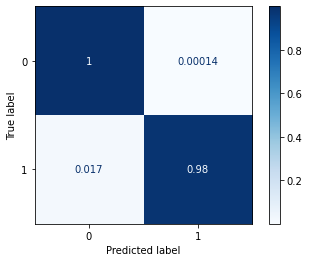

In [26]:
# view confusion matrix

plot_confusion_matrix(gs_svc, X_test, y_test, cmap = 'Blues', normalize = 'true');

In [27]:
### TfidfVectorizer()
#### Multinomial Naive Bayes and Support Vector Machine

In [28]:
# set up 2 pipelines with: 1. Multinomial Naive Bayes 2. SVC

pipe_mb_t = Pipeline([
                      ('tvec', TfidfVectorizer()),
                      ('mb', MultinomialNB())
                     ])

pipe_svc_t = Pipeline([
                       ('tvec', TfidfVectorizer()),
                       ('svc', SVC())
                      ])

In [29]:
# set up a dictionary to store the best parameters

t_mb_params = {}
t_count_mb = 0

t_svc_params = {}
t_count_svc = 0

In [30]:
# search over the following values of hyperparameters:

pipe_tvec_params = {
    'tvec__max_features': [4000],
    'tvec__stop_words': [stop_words, None],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'tvec__min_df': [0.001, 0.002, 0.003],
    'tvec__max_df': [0.85, 0.90, 0.95]
}

In [31]:
# instantiate GridSearchCV

gs_mb_t = GridSearchCV(pipe_mb_t,
                       param_grid = pipe_tvec_params,
                       cv = 3)

gs_svc_t = GridSearchCV(pipe_svc_t,
                        param_grid = pipe_tvec_params,
                        cv = 3)

In [32]:
# increase counter as we put in different parameters

t_count_mb += 1

# fit the training set

gs_mb_t.fit(X_train, y_train)

# best score is not captured in parameters -> create a key 'score' to store the info

gs_mb_t.best_params_['score'] = gs_mb_t.best_score_

t_mb_params[f'model_{t_count_mb}'] = gs_mb_t.best_params_

# dictionary to a dataframe

t_mb_df = pd.DataFrame.from_dict(t_mb_params, orient = 'index')

In [33]:
t_mb_df

,tvec__max_df,tvec__max_features,tvec__min_df,tvec__ngram_range,tvec__stop_words,score
model_1,0.85,4000,0.003,"(1, 1)","[i, me, my, myself, we, our, ours, ourselves, ...",0.898764


In [34]:
# increase counter as we put in different parameters

t_count_svc += 1

# fit the training set

gs_svc_t.fit(X_train, y_train)

# best score is not captured in parameters -> create a key 'score' to store the info

gs_svc_t.best_params_['score'] = gs_svc_t.best_score_

t_svc_params[f'model_{t_count_svc}'] = gs_svc_t.best_params_

# dictionary to a dataframe

t_svc_df = pd.DataFrame.from_dict(t_svc_params, orient = 'index')

In [35]:
t_svc_df

,tvec__max_df,tvec__max_features,tvec__min_df,tvec__ngram_range,tvec__stop_words,score
model_1,0.85,4000,0.002,"(1, 1)",None,0.990698


In [36]:
# best scores

print(f'Multinomial Naive Bayes: {gs_mb_t.best_score_}')
print(f'\nSVC: {gs_svc_t.best_score_}')

Multinomial Naive Bayes: 0.8987644369108739

SVC: 0.990697708723005


In [37]:
# train data accuracy score 

print(f'Multinomial Naive Bayes: {gs_mb_t.score(X_train, y_train)}')
print(f'\nSVC: {gs_svc_t.score(X_train, y_train)}')

Multinomial Naive Bayes: 0.9108284883720931

SVC: 0.999781976744186


In [38]:
# test data accuracy score 

print(f'Multinomial Naive Bayes: {gs_mb_t.score(X_test, y_test)}')
print(f'\nSVC: {gs_svc_t.score(X_test, y_test)}')

Multinomial Naive Bayes: 0.9069046916494541

SVC: 0.9954263794629684


In [39]:
# best estimators

print(f'Multinomial Naive Bayes: \n{gs_mb_t.best_estimator_}')
print(f'\nSVC: \n{gs_svc_t.best_estimator_}')

Multinomial Naive Bayes: 
Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.85, max_features=4000, min_df=0.003,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('mb', MultinomialNB())])

SVC: 
Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.85, max_features=4000, min_df=0.002)),
                ('svc', SVC())])


In [40]:
# best parameters

print(f'Multinomial Naive Bayes: \n{gs_mb_t.best_params_}')
print(f'\nSVC: \n{gs_svc_t.best_params_}')

Multinomial Naive Bayes: 
{'tvec__max_df': 0.85, 'tvec__max_features': 4000, 'tvec__min_df': 0.003, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', '

In [41]:
# predictions

y_preds_t = gs_svc_t.predict(X_test)

# confusion matrix values

tn, fp, fn, tp = confusion_matrix(y_test, y_preds_t).ravel()

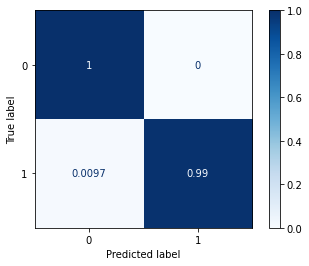

In [42]:
# view confusion matrix

plot_confusion_matrix(gs_svc_t, X_test, y_test, cmap = 'Blues', normalize = 'true');


In [44]:
### word2vec
#### Multinomial Naive Bayes and Support Vector Machine
#> Multinomial Naive Bayes did not work because of negative values.

In [45]:
# import gensim and create a model to vectorize the words

import gensim

file_path = '../vectors/lexvec.enwiki+newscrawl.300d.W.pos.vectors'

model = gensim.models.KeyedVectors.load_word2vec_format(file_path)

In [46]:
#### with stopwords

In [47]:
# create an empty list to store mean vector values from each row

vectors = [] 

# iterate through each row
for i in range(len(df['text_clean'])):
    
    # create an empty list to store vector values of each row
    vector = []
    
    # iterate through each word of each row
    for word in df['text_clean'][i].split(' '): 
        
        if word not in stop_words: 
        
            # if word is present in model, then vectorize
            try:
                word_vec = model[word] 
                # if word is present then append it to temporary dataframe
                vector.append(word_vec) 
        
            except:
                pass
    
    vectors.append(np.mean(vector))

In [48]:
# check if vectors have been created

print(len(df['text_clean']))
print(len(vectors))
vectors[:3]

41076
41076


[0.0027685475, 0.006268722, 0.00063196605]

In [49]:
# store vector values in the dataframe

df['vector_mean'] = vectors

# if null, fill null value as 0 --> foreign language still in UTF8 format

df['vector_mean'].fillna(0, inplace = True)

In [50]:
# setting X and y

X = df[['vector_mean']]
y = df['label']


# train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42, stratify = y)

In [51]:
# instantiate SVC

svc = SVC()

# fit

svc.fit(X_train, y_train)

# predict

y_pred = svc.predict(X_test)

# score

accuracy_score(y_test, y_pred)

0.5888905281794039

In [ ]:
#### without stopwords

In [52]:
# create an empty list to store mean vector values from each row

vectors = [] 

# iterate through each row
for i in range(len(df['text_clean'])):
    
    # create an empty list to store vector values of each row
    vector = []
    
    # iterate through each word of each row
    for word in df['text_clean'][i].split(' '): 
        
        try:
            word_vec = model[word] 
            vector.append(word_vec) 
        
        except:
            pass
    
    vectors.append(np.mean(vector))

In [53]:
# check if vectors have been created

print(len(df['text_clean']))
print(len(vectors))
vectors[:3]

41076
41076


[3.0706724e-05, 0.0032079108, -0.0008800765]

In [54]:
# store vector values in the dataframe

df['vector1_mean'] = vectors

# if null, fill null value as 0 --> foreign languages still in UTF8 format

df['vector1_mean'].fillna(0, inplace = True)

In [55]:
# setting X and y

X = df[['vector1_mean']]
y = df['label']


# train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42, stratify = y)

In [56]:
# instantiate SVC

svc = SVC()

# fit

svc.fit(X_train, y_train)

# predict

y_pred = svc.predict(X_test)

# score

accuracy_score(y_test, y_pred)

0.564030687518442